## Adapter trimming and barcode demultiplexing with Porechop

[Porechop](https://github.com/rrwick/Porechop) is a tool for finding and trimming adapters and demultiplexing barcoded ONT reads. Porechop commands and options are shown in the command usage:

In [ ]:
!porechop -h

Basic porechop command requires an input file (-i option) and output filename (after the '>' symbol). Porechop finds the adapters and puts the trimmed reads on the output. The following example does a basic trimming of an example input file. Porechop usage page (porechop -h) shows options for control end and middle adapter settings. Options are shown below:


In [1]:
!porechop -i data/1_out.fastq --threads 2 > data/porechoppped_output_reads.fastq


Loading reads
data/1_out.fastq
4,001 reads loaded


Looking for known adapter sets
4,001 / 4,001 (100.0%)
                                        Best               
                                        read       Best    
                                        start      read end
  Set                                   %ID        %ID     
  SQK-NSK007                                96.6       77.3
  Rapid                                    100.0        0.0
  SQK-MAP006                                80.0       79.2
  SQK-MAP006 Short                          76.9       76.9
  PCR adapters 1                            78.3       79.2
  PCR tail 1                                75.0       78.6
  PCR tail 2                                74.2       77.4
  1D^2 part 1                               74.2       74.1
  1D^2 part 2                               97.0       74.2
  Barcode 1 (reverse)                       73.1       79.2
  Barcode 2 (reverse)                       77.8     

Barcode demultiplexing can be done with the -b BARCODE_DIR option instead of defining the output file for trimmed reads. Reads are distributed in different bins (files) depending on their barcodes and these files are placed on BARCODE_DIR directory. We can also control the minimum match percentage of barcodes changing the threshold (--barcode_threshold) and add more options as shown on Porechop usage page.

Barcode demultiplexing is being done in Albacore since 1.0 version. In this case, note that Albacore demultiplexing and Porechop can disagree on the appropriate bin for a read. Porechop can performs its own demultiplexing on Albacore output, placing the reads in which both demultiplexing processes (Albacore and Porechop) disagree in the 'none' bin.


In [ ]:
!porechop -i data/porechop/1_out.fastq -b data/porechop/demultiplexed --threads 48

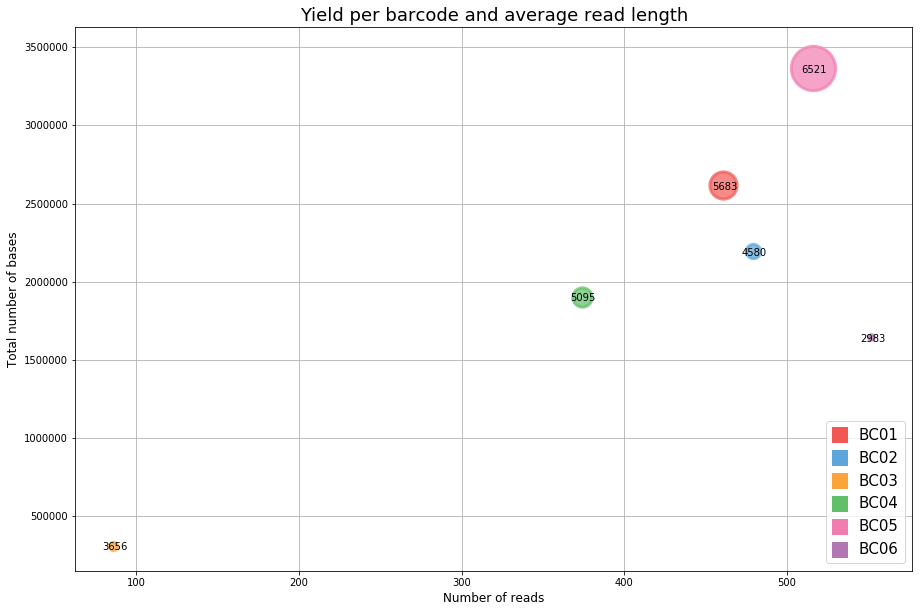

In [110]:
#!/usr/bin/python

import sys
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from Bio import SeqIO
matplotlib.rcParams['figure.figsize'] = (15, 10)

barcode_dir = 'data/porechop/demultiplexed/'
#Modify this list with an element per barcode (6 in the example)
barcode_files = ['BC01', 'BC02', 'BC03', 'BC04', 'BC05', 'BC06']

avg_lenghts = []
bases_cnt = []
read_cnt = []

#Bin files parser
def read_bin(filename):
    read_lenghts = []
    count = 0
    for seq_record in SeqIO.parse(filename, 'fastq'):
        read_lenghts.append(len(seq_record.seq))
        count += 1

    avg_lenghts.append(sum(read_lenghts)/len(read_lenghts))
    bases_cnt.append(sum(read_lenghts))
    read_cnt.append(count)

for bin_file in barcode_files:
    read_bin(barcode_dir + str(bin_file) + '.fastq')

#One colour per barcode (6 + none colour in the example)
colors = ['#F15854', '#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0', '#B276B2', '#DECF3F']

#Size of each point depending on the average read lengths
s = [3.2**(n/1000) for n in avg_lenghts]

#Draw the points and annotations
fig, ax = plt.subplots()
for index, barcode in enumerate(barcode_files, start=0):
    ax.scatter(read_cnt[index],bases_cnt[index],s=s[index],c=colors[index],label=barcode, alpha=0.7, linewidth=3)
    ax.annotate(int(avg_lenghts[index]), (read_cnt[index] - 7,bases_cnt[index] - 10**4.5))

#Legend
handles = [mpatches.Patch(color=color, label=barcode) for color, barcode, avg_length in zip(colors, barcode_files, avg_lenghts)]
ax.legend(handles=handles, loc=4, prop={'size': 15}, fontsize=9, frameon=True)

#Title and axes text
plt.title('Yield per barcode and average read length', fontsize=18)
plt.xlabel('Number of reads', fontsize=12)
plt.ylabel('Total number of bases', fontsize=12)

ax.grid(True)

plt.show()